# Double conditional recurrent neural network for pulse propagation
This notebook shows how to create and save a conditional LSTM neural network, with two conditional parameters

#### Import relevant modules

In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input
from cond_rnn import ConditionalRecurrent

#### Define the network variables
The variables of the network depend on the data that will be fed and predicted to and by the network. 

The <strong>sequence length</strong> is the number of sequential observations the model is fed as the input, similarly to a traditional recurrent network. <br>
The <strong>number of features in the sequence</strong> is the number of points in each observation. In the case of a prediction of the evolution of the spectral intensity profile, this corresponds to the number of spectral points. <br>
The <strong>number of features of the conditional parameters</strong>, similarly, are the number of points within each condition. <br>
The <strong>number of units</strong> is the number of LSTM cells, just like a standard LSTM network. <br>
We also need to define the <strong>activation function</strong> of the output Dense layer. This depends on the normalization of the data. For instance, when predicting the spectral intensity, normalized from 0 to 1, a _sigmoid_ activation function is used. On the other hand, the prediction of the Real and Imaginary components of the complex envelope, which are normalized in the [-1,1] range, uses a _tanh_ activation function.

Finally, define a name for the model to be saved.

In [2]:
# Sequence length
l_seq = 10

# Number of features in the sequence
n_features = 500

# Number of features in the first conditional parameter
cond_1_features = 1

# Number of features in the second conditional parameter
cond_2_features = 1

# Number of LSTM units
lstm_units = 128

# Activation function of the Dense layer
a_func = 'tanh'

# Model name
model_name = 'dual_cond_LSTM.h5'

#### Create the model
The model is created via the Keras Functional API.
We start by defining the tensors for each input, then combine them and build the model.

In [3]:
# Sequence
i = Input(shape=[l_seq, n_features], name='sequential input')

# First conditional parameter
c_1 = Input(shape=[cond_1_features], name='conditional parameter 1')

# Second conditional parameter
c_2 = Input(shape=[cond_2_features], name='conditional parameter 2')

# Combine the sequence and the first condition into a conditional LSTM layer
x = ConditionalRecurrent(LSTM(n_features, return_sequences=True, name='cond_LSTM_1'))([i, c_1])

# Combine with the second condition into a conditional LSTM layer
x = ConditionalRecurrent(LSTM(n_features, return_sequences=True, name='cond_LSTM_2'))([x, c_2])

# Combine with the first condition again, into a conditional LSTM layer
x = ConditionalRecurrent(LSTM(n_features, return_sequences=True, name='cond_LSTM_3'))([x, c_1])

# Combine with the second condition again, into a conditional LSTM layer
x = ConditionalRecurrent(LSTM(n_features, return_sequences=False, name='cond_LSTM_4'))([x, c_2])

# Finally, the output Dense layer
x = Dense(units=n_features, activation=a_func, name='output')(x)

# Build the model from the tensors
model = Model(inputs=[i, c_1, c_2], outputs=[x])

# Compile the model
model.compile(optimizer='adam',loss='mae')

2024-04-14 17:54:49.271212: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-14 17:54:49.271402: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


#### Save the model

In [4]:
model.save(model_name)

#### Print the summary of the model

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequential input (InputLayer)  [(None, 10, 500)]    0           []                               
                                                                                                  
 conditional parameter 1 (Input  [(None, 1)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 conditional_recurrent (Conditi  (None, 10, 500)     2003000     ['sequential input[0][0]',       
 onalRecurrent)                                                   'conditional parameter 1[0][0]']
                                                                                              

#### Plot the model via the Keras utility

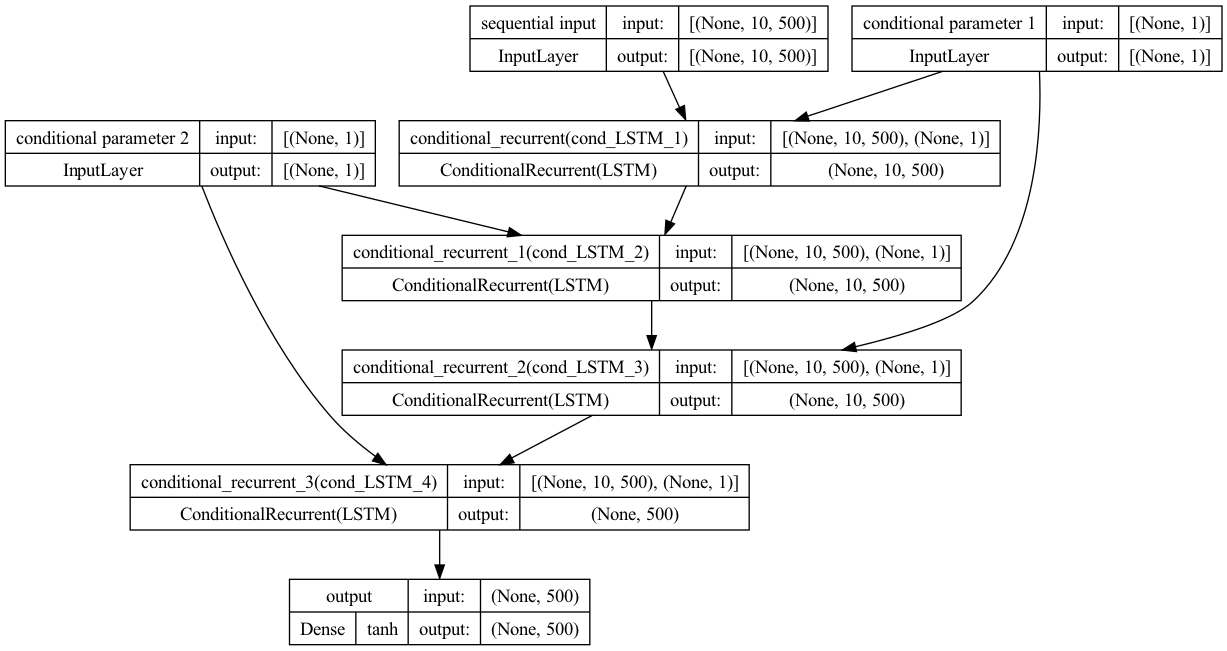

In [5]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    dpi=96,
    show_layer_activations=True,
)